In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/FYP'
os.chdir(folder_path)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found


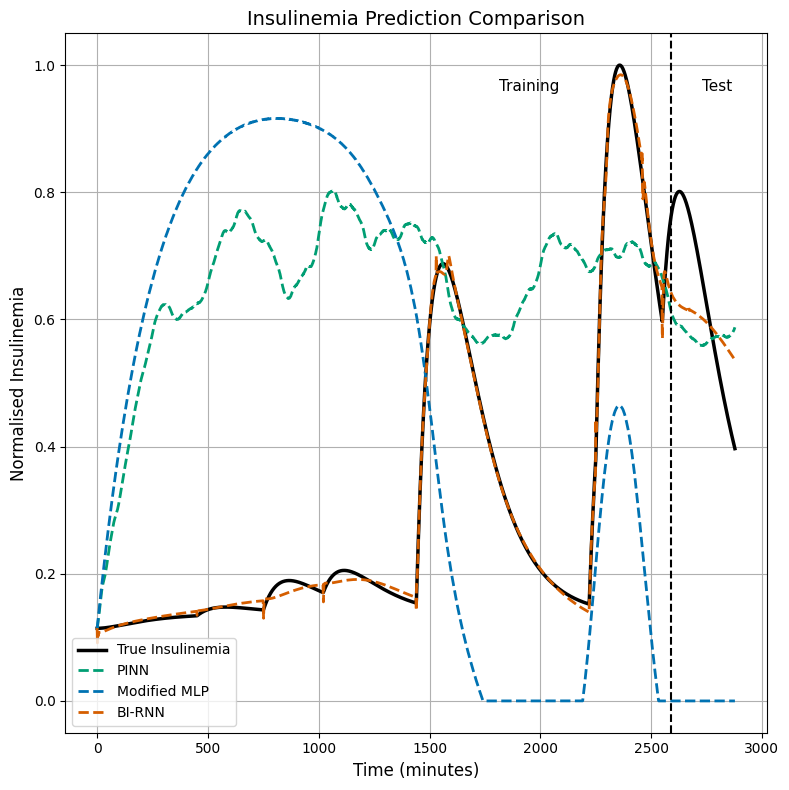

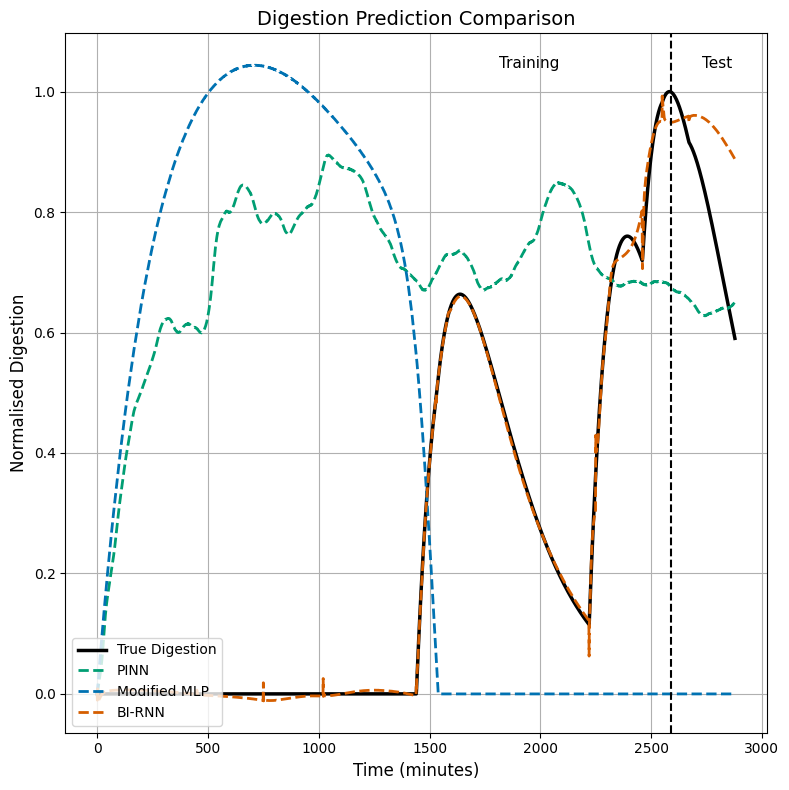

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Load saved prediction files ===
pinn = np.load("predictions_PINN_IandD.npz")
mlp = np.load("predictions_ModMLP_IandD.npz")
gru = np.load("predictions_GRU_IandD.npz")

# === Truncate to match minimum length ===
min_len = min([
    pinn["I_pred"].shape[0],
    mlp["I_pred"].shape[0],
    gru["I_pred"].shape[0],
    pinn["I_true"].shape[0],
    pinn["time"].shape[0],
])

time = pinn["time"][:min_len]
I_true = pinn["I_true"][:min_len]
D_true = pinn["D_true"][:min_len]

I_preds = {
    "PINN": pinn["I_pred"][:min_len],
    "Modified MLP": mlp["I_pred"][:min_len],
    "BI-RNN": gru["I_pred"][:min_len]
}
D_preds = {
    "PINN": pinn["D_pred"][:min_len],
    "Modified MLP": mlp["D_pred"][:min_len],
    "BI-RNN": gru["D_pred"][:min_len]
}

# === Model-specific styles ===
model_styles = {
    "PINN": dict(color="#009E73", linestyle="--"),         # green
    "Modified MLP": dict(color="#0072B2", linestyle="--"), # blue
    "BI-RNN": dict(color="#D55E00", linestyle="--")        # deep orange-red
}


split_time = time[int(0.9 * len(time))]

# === Insulinemia Plot ===
plt.figure(figsize=(8, 8))
plt.plot(time, I_true, label="True Insulinemia", color="black", linewidth=2.5)
for label, pred in I_preds.items():
    style = model_styles[label]
    plt.plot(time, pred, label=label, linewidth=2.0, **style)

plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
plt.text(1950, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Insulinemia", fontsize=12)
plt.title("Insulinemia Prediction Comparison", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("I_trace_comparison.png", dpi=600, bbox_inches="tight")
plt.show()

# === Digestion Plot ===
plt.figure(figsize=(8, 8))
plt.plot(time, D_true, label="True Digestion", color="black", linewidth=2.5)
for label, pred in D_preds.items():
    style = model_styles[label]
    plt.plot(time, pred, label=label, linewidth=2.0, **style)

plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
plt.text(1950, 1.04, 'Training', ha='center', fontsize=11)
plt.text(2800, 1.04, 'Test', ha='center', fontsize=11)
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Digestion", fontsize=12)
plt.title("Digestion Prediction Comparison", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("D_trace_comparison.png", dpi=600, bbox_inches="tight")
plt.show()


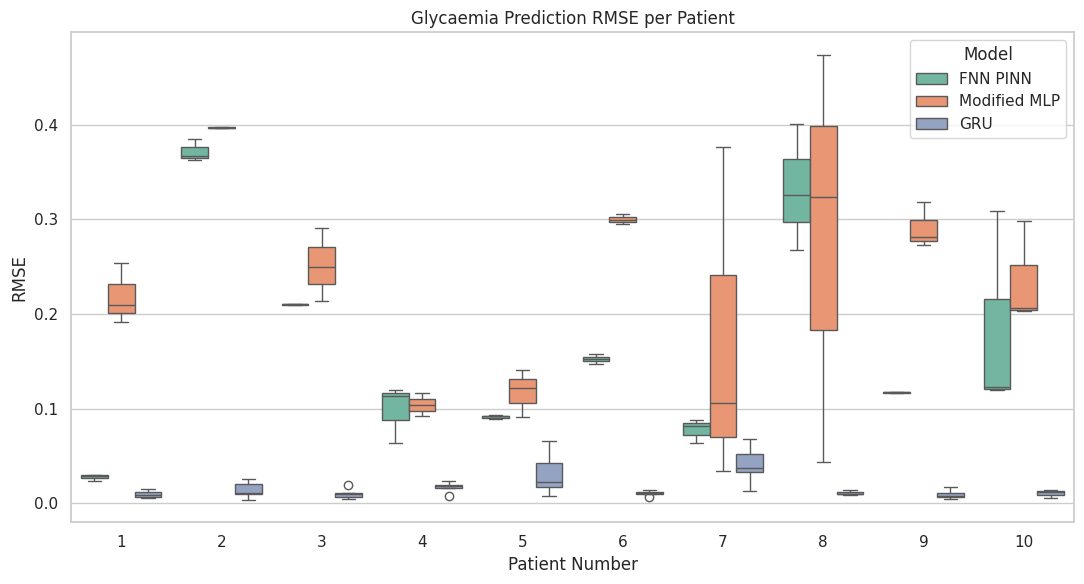

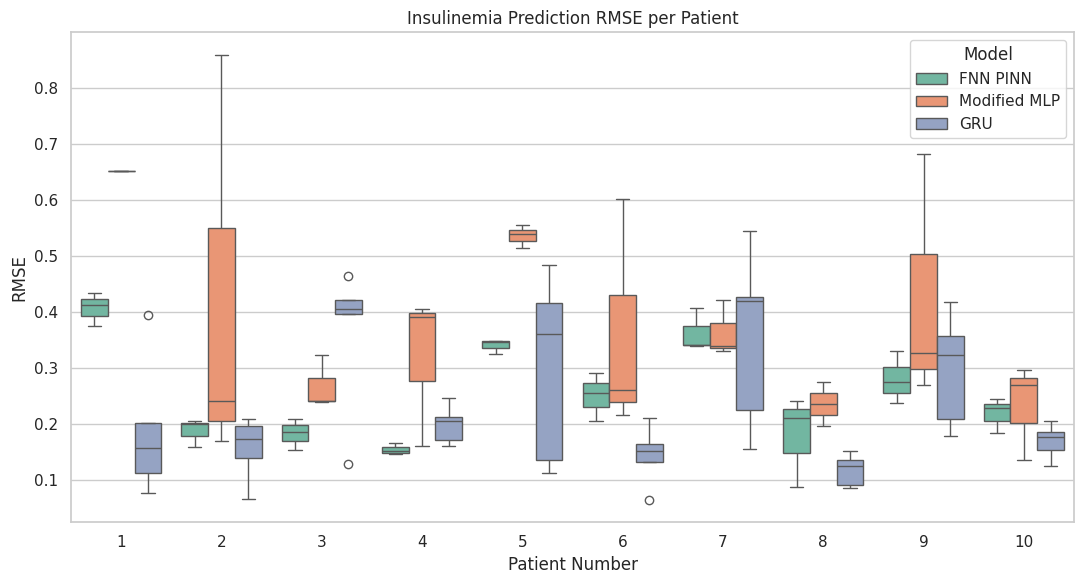

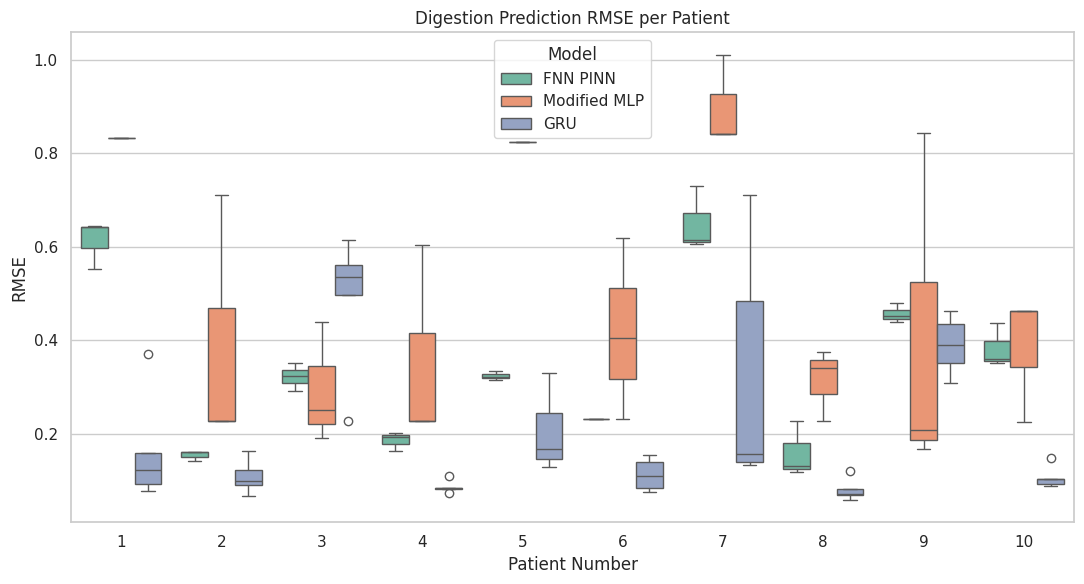

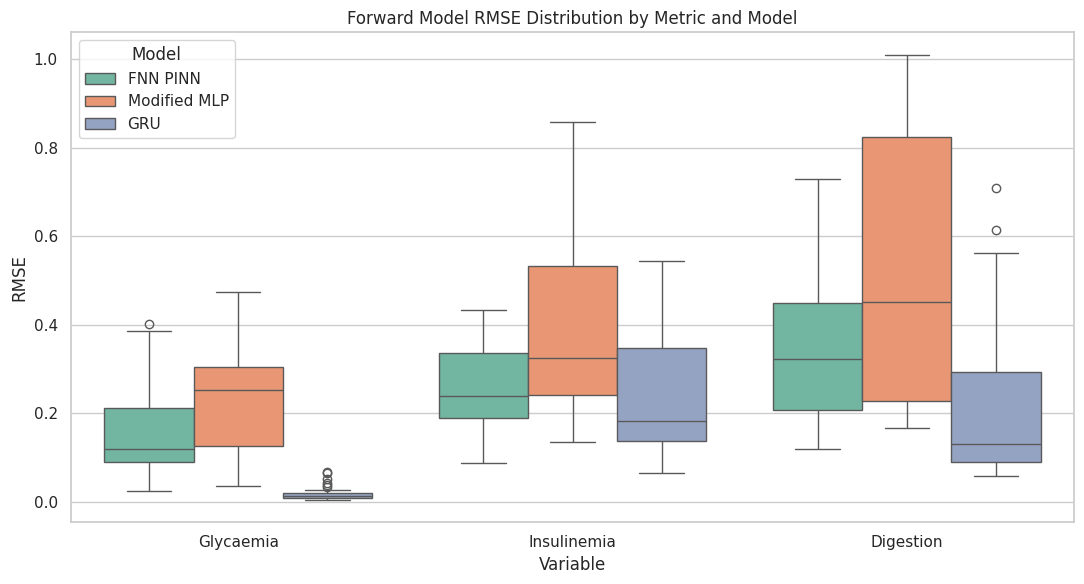

Mean and Standard Deviation of RMSE per Metric:


,Model,RMSE_mean_Digestion,RMSE_mean_Glycaemia,RMSE_mean_Insulinemia,RMSE_std_Digestion,RMSE_std_Glycaemia,RMSE_std_Insulinemia
0,FNN PINN,0.3478,0.1661,0.2562,0.1759,0.1129,0.0908
1,GRU,0.2062,0.0164,0.2290,0.1698,0.0141,0.1274
2,Modified MLP,0.5112,0.2366,0.3813,0.2791,0.1156,0.1878


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Files ===
file_fnn = pd.read_csv("forward_inverse_ksi_rmse_results.csv")
file_mlp = pd.read_csv("ModMLP_forward_inverse_ksi_rmse_results.csv")
file_gru = pd.read_csv("gru_forward_estimates_all_patientsSYNTHETIC.csv")

# Shift patient IDs by -1
file_fnn["Patient"] -= 1
file_mlp["Patient"] -= 1
file_gru["Patient"] -= 1

# === Prepare RMSE Data ===
def prepare_rmse_df(df, model_name, g_col, i_col, d_col):
    df_long = pd.DataFrame({
        "Patient": df["Patient"],
        "G_RMSE": df[g_col],
        "I_RMSE": df[i_col],
        "D_RMSE": df[d_col],
    })
    df_long = df_long.melt(id_vars=["Patient"], var_name="Metric", value_name="RMSE")
    df_long["Model"] = model_name
    return df_long

df_fnn = prepare_rmse_df(file_fnn, "FNN PINN", "G_RMSE", "I_RMSE", "D_RMSE")
df_mlp = prepare_rmse_df(file_mlp, "Modified MLP", "G_RMSE", "I_RMSE", "D_RMSE")
df_gru = prepare_rmse_df(file_gru.rename(columns={"RMSE_G": "G_RMSE", "RMSE_I": "I_RMSE", "RMSE_D": "D_RMSE"}),
                         "GRU", "G_RMSE", "I_RMSE", "D_RMSE")

rmse_df = pd.concat([df_fnn, df_mlp, df_gru], ignore_index=True)
rmse_df["Metric"] = rmse_df["Metric"].replace({
    "G_RMSE": "Glycaemia",
    "I_RMSE": "Insulinemia",
    "D_RMSE": "Digestion"
})


g_df = rmse_df[rmse_df["Metric"] == "Glycaemia"].copy()
i_df = rmse_df[rmse_df["Metric"] == "Insulinemia"].copy()
d_df = rmse_df[rmse_df["Metric"] == "Digestion"].copy()

# === Plot RMSE per Patient for Glucose ===
sns.set(style="whitegrid")
plt.figure(figsize=(11, 6))
sns.boxplot(data=g_df, x="Patient", y="RMSE", hue="Model", palette="Set2")
plt.title("Glycaemia Prediction RMSE per Patient")
plt.ylabel("RMSE")
plt.xlabel("Patient Number")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("RMSE_G.png", dpi=600, bbox_inches="tight")
plt.show()

# === Plot RMSE per Patient for Insulin ===
plt.figure(figsize=(11, 6))
sns.boxplot(data=i_df, x="Patient", y="RMSE", hue="Model", palette="Set2")
plt.title("Insulinemia Prediction RMSE per Patient")
plt.ylabel("RMSE")
plt.xlabel("Patient Number")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("RMSE_I.png", dpi=600, bbox_inches="tight")
plt.show()

# === Plot RMSE per Patient for CHO Digestion ===
plt.figure(figsize=(11, 6))
sns.boxplot(data=d_df, x="Patient", y="RMSE", hue="Model", palette="Set2")
plt.title("Digestion Prediction RMSE per Patient")
plt.ylabel("RMSE")
plt.xlabel("Patient Number")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("RMSE_D.png", dpi=600, bbox_inches="tight")
plt.show()

# === Plot RMSE ===
sns.set(style="whitegrid")
plt.figure(figsize=(11, 6))
sns.boxplot(data=rmse_df, x="Metric", y="RMSE", hue="Model", palette="Set2")
plt.title("Forward Model RMSE Distribution by Metric and Model")
plt.ylabel("RMSE")
plt.xlabel("Variable")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("ForwardSyntheticFULL.png", dpi=600, bbox_inches="tight")
plt.show()

# === Prepare and Plot KSI Relative Error ===
true_vals_map = dict(zip(range(1, 11), [197, 274, 191, 282, 203, 267, 200, 272, 191, 282]))

def extract_ksi_error(df, model_name, ksi_col="ksi"):
    sub = df.copy()
    sub["Model"] = model_name
    sub["Rel_KSI_Error"] = (sub[ksi_col] - sub["Patient"].map(true_vals_map)) / sub["Patient"].map(true_vals_map) * 100
    return sub[["Patient", "Model", "Rel_KSI_Error"]]

err_fnn = extract_ksi_error(file_fnn, "FNN PINN")
err_mlp = extract_ksi_error(file_mlp, "Modified MLP")
err_gru = extract_ksi_error(file_gru.rename(columns={"Final_ksi": "ksi"}), "GRU")

ksi_err_df = pd.concat([err_fnn, err_mlp, err_gru], ignore_index=True)

# === Plot KSI Relative Error ===
# plt.figure(figsize=(11, 6))
# sns.boxplot(data=ksi_err_df, x="Patient", y="Rel_KSI_Error", hue="Model", palette="Set2")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title("Relative Error in Inferred KSI for Forward Models")
# plt.ylabel("Relative Error in KSI (%)")
# plt.xlabel("Patient Number")
# plt.legend(title="Model")
# plt.tight_layout()
# plt.savefig("JointForwardInverseSynthetic.png", dpi=600, bbox_inches="tight")
# plt.show()

# === Compute per-patient, per-model summary (mean + std) for each RMSE metric ===
metric_summary = (
    rmse_df.groupby(["Metric", "Model"])["RMSE"]
    .agg(["mean", "std"])
    .reset_index()
    .pivot(index="Model", columns="Metric")
)

# Flatten MultiIndex columns for easier access
metric_summary.columns = [f"{stat}_{metric}" for stat, metric in metric_summary.columns]
metric_summary = metric_summary.reset_index()

# Optional: Round values for readability
metric_summary.iloc[:, 1:] = metric_summary.iloc[:, 1:].round(4)

# Optional: Rename for clarity
metric_summary.columns = (
    ["Model"] +
    [col.replace("mean", "RMSE_mean").replace("std", "RMSE_std") for col in metric_summary.columns[1:]]
)

# Display the summary table
from IPython.display import display

print("Mean and Standard Deviation of RMSE per Metric:")
display(metric_summary)



In [ ]:
import pandas as pd
from IPython.display import display

# === Compute per-patient, per-model, per-metric RMSE summary ===
rmse_summary = (
    rmse_df.groupby(["Patient", "Model", "Metric"])["RMSE"]
    .agg(["mean", "std"])
    .reset_index()
    .pivot(index="Patient", columns=["Model", "Metric"])
)

# === Flatten MultiIndex columns ===
rmse_summary.columns = [f"{stat}_{model}_{metric}" for stat, model, metric in rmse_summary.columns]
rmse_summary = rmse_summary.reset_index()

# === Round numeric values for readability ===
rmse_summary.iloc[:, 1:] = rmse_summary.iloc[:, 1:].round(4)

# === Display final summary table ===
print("Per-patient RMSE mean and std for each model and variable:")
display(rmse_summary)

rmse_summary.to_csv("rmse_patient_summary.csv", index=False)


Per-patient RMSE mean and std for each model and variable:


,Patient,mean_FNN PINN_Digestion,mean_FNN PINN_Glycaemia,mean_FNN PINN_Insulinemia,mean_GRU_Digestion,mean_GRU_Glycaemia,mean_GRU_Insulinemia,mean_Modified MLP_Digestion,mean_Modified MLP_Glycaemia,mean_Modified MLP_Insulinemia,std_FNN PINN_Digestion,std_FNN PINN_Glycaemia,std_FNN PINN_Insulinemia,std_GRU_Digestion,std_GRU_Glycaemia,std_GRU_Insulinemia,std_Modified MLP_Digestion,std_Modified MLP_Glycaemia,std_Modified MLP_Insulinemia
0,1,0.6129,0.0275,0.4063,0.1648,0.0097,0.1884,0.8332,0.2182,0.6504,0.0525,0.0033,0.0300,0.1197,0.0039,0.1243,0.0000,0.0321,0.0000
1,2,0.1543,0.3713,0.1876,0.1080,0.0140,0.1565,0.3885,0.3968,0.4229,0.0106,0.0121,0.0257,0.0364,0.0089,0.0567,0.2791,0.0007,0.3791
2,3,0.3223,0.2103,0.1826,0.4869,0.0102,0.3624,0.2937,0.2515,0.2680,0.0297,0.0006,0.0282,0.1517,0.0057,0.1335,0.1292,0.0384,0.0476
3,4,0.1855,0.0987,0.1546,0.0862,0.0172,0.1990,0.3528,0.1037,0.3190,0.0202,0.0302,0.0108,0.0142,0.0057,0.0343,0.2182,0.0121,0.1368
4,5,0.3236,0.0916,0.3398,0.2037,0.0311,0.3014,0.8243,0.1177,0.5359,0.0095,0.0021,0.0126,0.0836,0.0230,0.1677,0.0000,0.0250,0.0204
5,6,0.2309,0.1524,0.2503,0.1128,0.0109,0.1443,0.4183,0.2999,0.3592,0.0000,0.0048,0.0428,0.0343,0.0025,0.0531,0.1945,0.0054,0.2104
6,7,0.6502,0.0776,0.3622,0.3243,0.0404,0.3538,0.8983,0.1719,0.3635,0.0699,0.0127,0.0386,0.2615,0.0203,0.1596,0.0977,0.1803,0.0498
7,8,0.1593,0.3315,0.1797,0.0797,0.0109,0.1182,0.3141,0.2801,0.2353,0.0592,0.0666,0.0817,0.0236,0.0020,0.0283,0.0769,0.2185,0.0394
8,9,0.4568,0.1169,0.2803,0.3888,0.0092,0.2968,0.4061,0.2906,0.4255,0.0203,0.0005,0.0466,0.0615,0.0049,0.1011,0.3799,0.0242,0.2229
9,10,0.3827,0.1836,0.2186,0.1071,0.0107,0.1690,0.3832,0.2356,0.2332,0.0475,0.1087,0.0319,0.0236,0.0035,0.0309,0.1375,0.0542,0.0862


In [ ]:
file_gru["Rel_Deviation"] = (file_gru["Final_ksi"] - file_gru["Initial_ksi"]) / file_gru["Initial_ksi"]

mean_rel_dev = file_gru.groupby("Patient")["Rel_Deviation"].mean().reset_index()
mean_rel_dev["Rel_Deviation (%)"] = mean_rel_dev["Rel_Deviation"] * 100

print(mean_rel_dev)

   Patient  Rel_Deviation  Rel_Deviation (%)
0        1            0.0                0.0
1        2            0.0                0.0
2        3            0.0                0.0
3        4            0.0                0.0
4        5            0.0                0.0
5        6            0.0                0.0
6        7            0.0                0.0
7        8            0.0                0.0
8        9            0.0                0.0
9       10            0.0                0.0


<ipython-input-4-3229e226280f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rel_combined_df, x="Model", y="Rel_Error", palette="Set2")


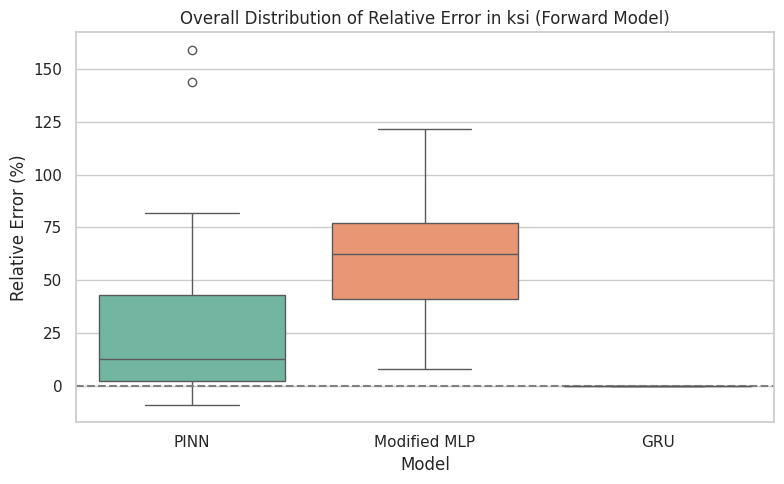

In [ ]:
# === Function to compute all relative errors per run across patients
def extract_rel_errors(df, model_name, ksi_col="ksi"):
    df = df.copy()
    df["Model"] = model_name
    df["True_KSI"] = df["Patient"].map(true_vals_map)
    df["Rel_Error"] = (df[ksi_col] - df["True_KSI"]) / df["True_KSI"] * 100
    return df[["Model", "Rel_Error"]]

# === Apply to each model ===
rel_fnn = extract_rel_errors(file_fnn, "PINN")
rel_mlp = extract_rel_errors(file_mlp, "Modified MLP")
rel_gru = extract_rel_errors(file_gru.rename(columns={"Final_ksi": "ksi"}), "GRU")

# === Combine all for plotting
rel_combined_df = pd.concat([rel_fnn, rel_mlp, rel_gru], ignore_index=True)

# === Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(data=rel_combined_df, x="Model", y="Rel_Error", palette="Set2")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Overall Distribution of Relative Error in ksi (Forward Model)")
plt.ylabel("Relative Error (%)")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("JointForwardInverseSyntheticFULL.png", dpi=600, bbox_inches="tight")
plt.show()

<ipython-input-22-b014ffe71446>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="Model", y="G_RMSE", palette="Set2")


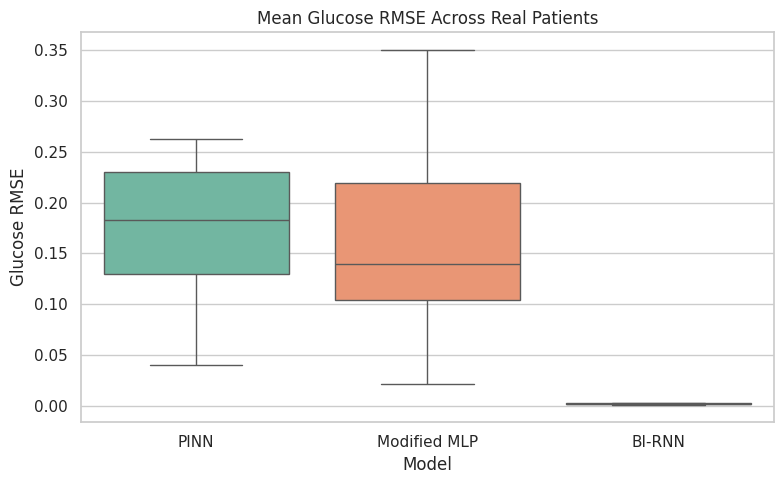

<ipython-input-22-b014ffe71446>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x="Model", y="G_RMSE", palette="Set2", order=["PINN", "Modified MLP", "BI-RNN"])


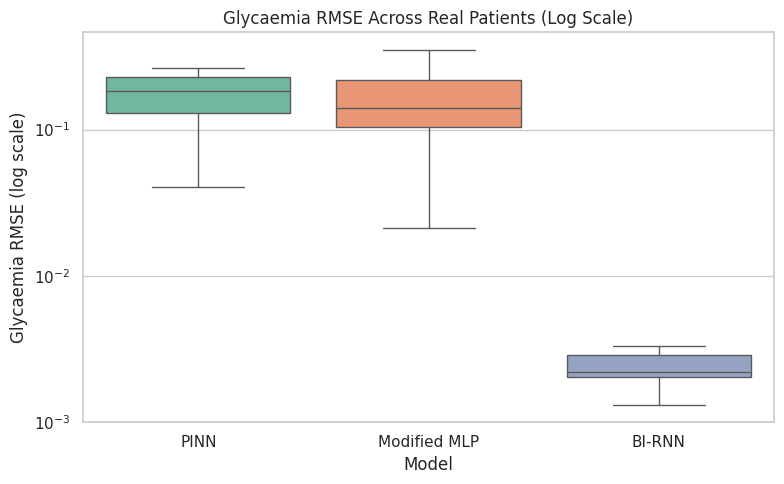

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/content/drive/My Drive/FYP/wide_format')

# Load your files
pinn_df = pd.read_csv("RealPINNrmse_results.csv")
mlp_df = pd.read_csv("RealMODMLPrmse_results.csv")
birnn_df = pd.read_csv("RealBIRNNrmse_results.csv")



pinn_df = pd.read_csv("RealPINNrmse_results.csv")
mlp_df = pd.read_csv("RealMODMLPrmse_results.csv")
birnn_df = pd.read_csv("RealBIRNNrmse_results.csv").rename(columns={"RMSE_G": "G_RMSE"})

pinn_df["Model"] = "PINN"
mlp_df["Model"] = "Modified MLP"
birnn_df["Model"] = "BI-RNN"

# === Combine and reorder models as desired ===
df_all = pd.concat([pinn_df, mlp_df, birnn_df], ignore_index=True)
model_order = ["PINN", "Modified MLP", "BI-RNN"]

# === Plot using seaborn ===
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_all, x="Model", y="G_RMSE", palette="Set2")
plt.title("Mean Glucose RMSE Across Real Patients")
plt.ylabel("Glucose RMSE")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("RealPatientRMSE_PerModel.png", dpi=600, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_all, x="Model", y="G_RMSE", palette="Set2", order=["PINN", "Modified MLP", "BI-RNN"])
plt.yscale("log")
plt.title("Glycaemia RMSE Across Real Patients (Log Scale)")
plt.ylabel("Glycaemia RMSE (log scale)")
plt.xlabel("Model")
plt.tight_layout()
plt.savefig("RealPatientRMSE_PerModel_LOG.png", dpi=600, bbox_inches="tight")
plt.show()



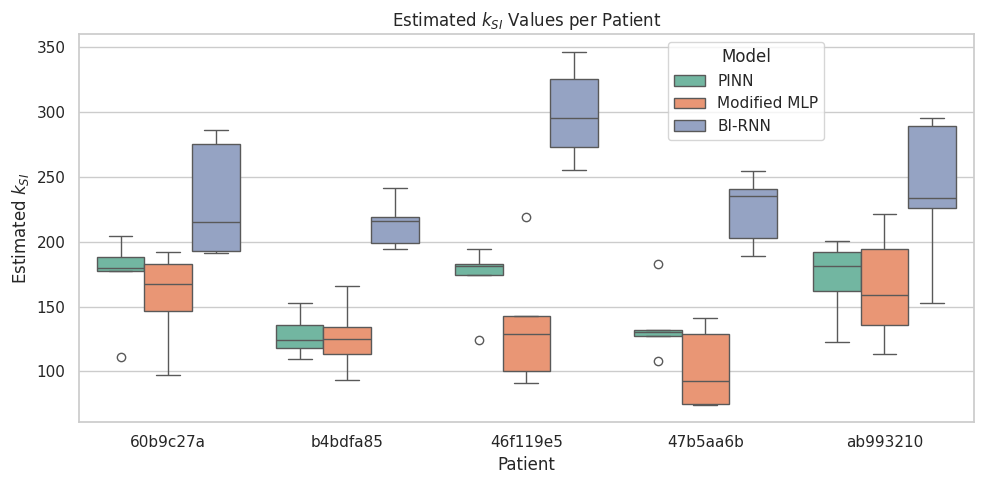

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
pinn_df = pd.read_csv("RealPINNrmse_results.csv")
mlp_df = pd.read_csv("RealMODMLPrmse_results.csv")
birnn_df = pd.read_csv("RealBIRNNrmse_results.csv").rename(columns={"Final_ksi": "ksi", "RMSE_G": "G_RMSE"})

# Label each model
pinn_df["Model"] = "PINN"
mlp_df["Model"] = "Modified MLP"
birnn_df["Model"] = "BI-RNN"

# Subset to required columns
pinn_ksi = pinn_df[["Patient", "ksi", "Model"]]
mlp_ksi = mlp_df[["Patient", "ksi", "Model"]]
birnn_ksi = birnn_df[["Patient", "ksi", "Model"]]

# Combine all
df_all_ksi = pd.concat([pinn_ksi, mlp_ksi, birnn_ksi], ignore_index=True)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_all_ksi, x="Patient", y="ksi", hue="Model", palette="Set2")
# sns.stripplot(data=df_all_ksi, x="Patient", y="ksi", hue="Model",
#               dodge=True, marker="o", alpha=0.6, linewidth=0.5, palette="Set2")

plt.title("Estimated $k_{SI}$ Values per Patient")
plt.ylabel("Estimated $k_{SI}$")
plt.xlabel("Patient")
plt.legend(title="Model", bbox_to_anchor=(0.65, 1), loc="upper left")
plt.tight_layout()
plt.savefig("RealPatient_ksi_PerPatient.png", dpi=600, bbox_inches="tight")
plt.show()
